In [1]:
#Stacked Ensemble

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Thailand.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 → predict 2011–2021

# === 4. Train Base Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Base Predictions for 2011–2022 ===
series = list(land_used[:3])  # Start from 2008–2010
actual = land_used[3:]       # Ground truth: 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []
stacked_features = []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)

    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]

    # Save base model predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)

    # Collect features for stacking
    stacked_features.append([arima_pred, rf_pred, xgb_pred, lstm_pred, gru_pred])

    # Update sequence for next iteration (using rf_pred arbitrarily)
    series.append(rf_pred)

# === 7. Stacking: Train Meta Model ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
print("\nYear-wise Prediction Table:\n", pred_table.to_string(index=False))



Model Evaluation Table:
                         R2           RMSE            MAE
ARIMA             0.278711  159356.902184  117519.418703
Random Forest     0.424780  142309.218510   89733.316667
XGBoost           0.448263  139374.084788   65510.812500
LSTM              0.144138  173587.310041  146695.395833
GRU              -0.000157  187650.699357  170254.979167
Stacked Ensemble  0.945462   43819.383585   32724.619566

Year-wise Prediction Table:
  Year    Actual        ARIMA  Random Forest     XGBoost        LSTM         GRU  Stacked Ensemble
 2011 1259240.0 1.002496e+06     1279711.45 1259240.375 1179387.875 1080062.875      1.209113e+06
 2012 1282082.0 1.260063e+06     1297442.43 1282082.125 1180015.625 1110019.125      1.314060e+06
 2013 1321595.0 1.033106e+06     1324529.62 1321595.125 1202237.625 1146170.000      1.361693e+06
 2014 1353025.0 1.323156e+06     1377984.52 1353024.625 1261437.750 1208401.500      1.337735e+06
 2015 1400748.0 1.375189e+06     1418727.08 1400748.375

In [11]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Thailand_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

start_idx = years.index(2005)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast ===
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(16):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # arbitrary update, could be mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": abs(r2_score(y_true,y_pred)),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))



📊 Model Evaluation Table:
                         R2           RMSE            MAE
ARIMA             1.774573  417068.115595  356204.511898
LSTM              0.399173  296172.457067  241841.273438
GRU               0.317389  287386.251683  230740.226562
Stacked Ensemble  0.712425  134271.623235   94646.104339
Random Forest     1.763501  416235.171074  351358.967188
XGBoost           2.280570  453506.572853  384693.546875
Decision Tree     2.325697  456615.122428  387526.895833
SVM               1.808198  419587.789500  356974.378163
Gradient Boost    2.086510  439888.655123  373572.122731

📅 Year-wise Prediction Table:
  Year    Actual        ARIMA        LSTM         GRU  Stacked Ensemble  Random Forest      XGBoost  Decision Tree          SVM  Gradient Boost
 2008 1054108.0 1.115312e+06 1253673.500 1280118.375      1.054108e+06    1062700.575 1008210.5625   1.009112e+06 1.097519e+06    1.008173e+06
 2009  963646.0 1.055491e+06 1264788.125 1276285.125      9.629070e+05    1054901.42

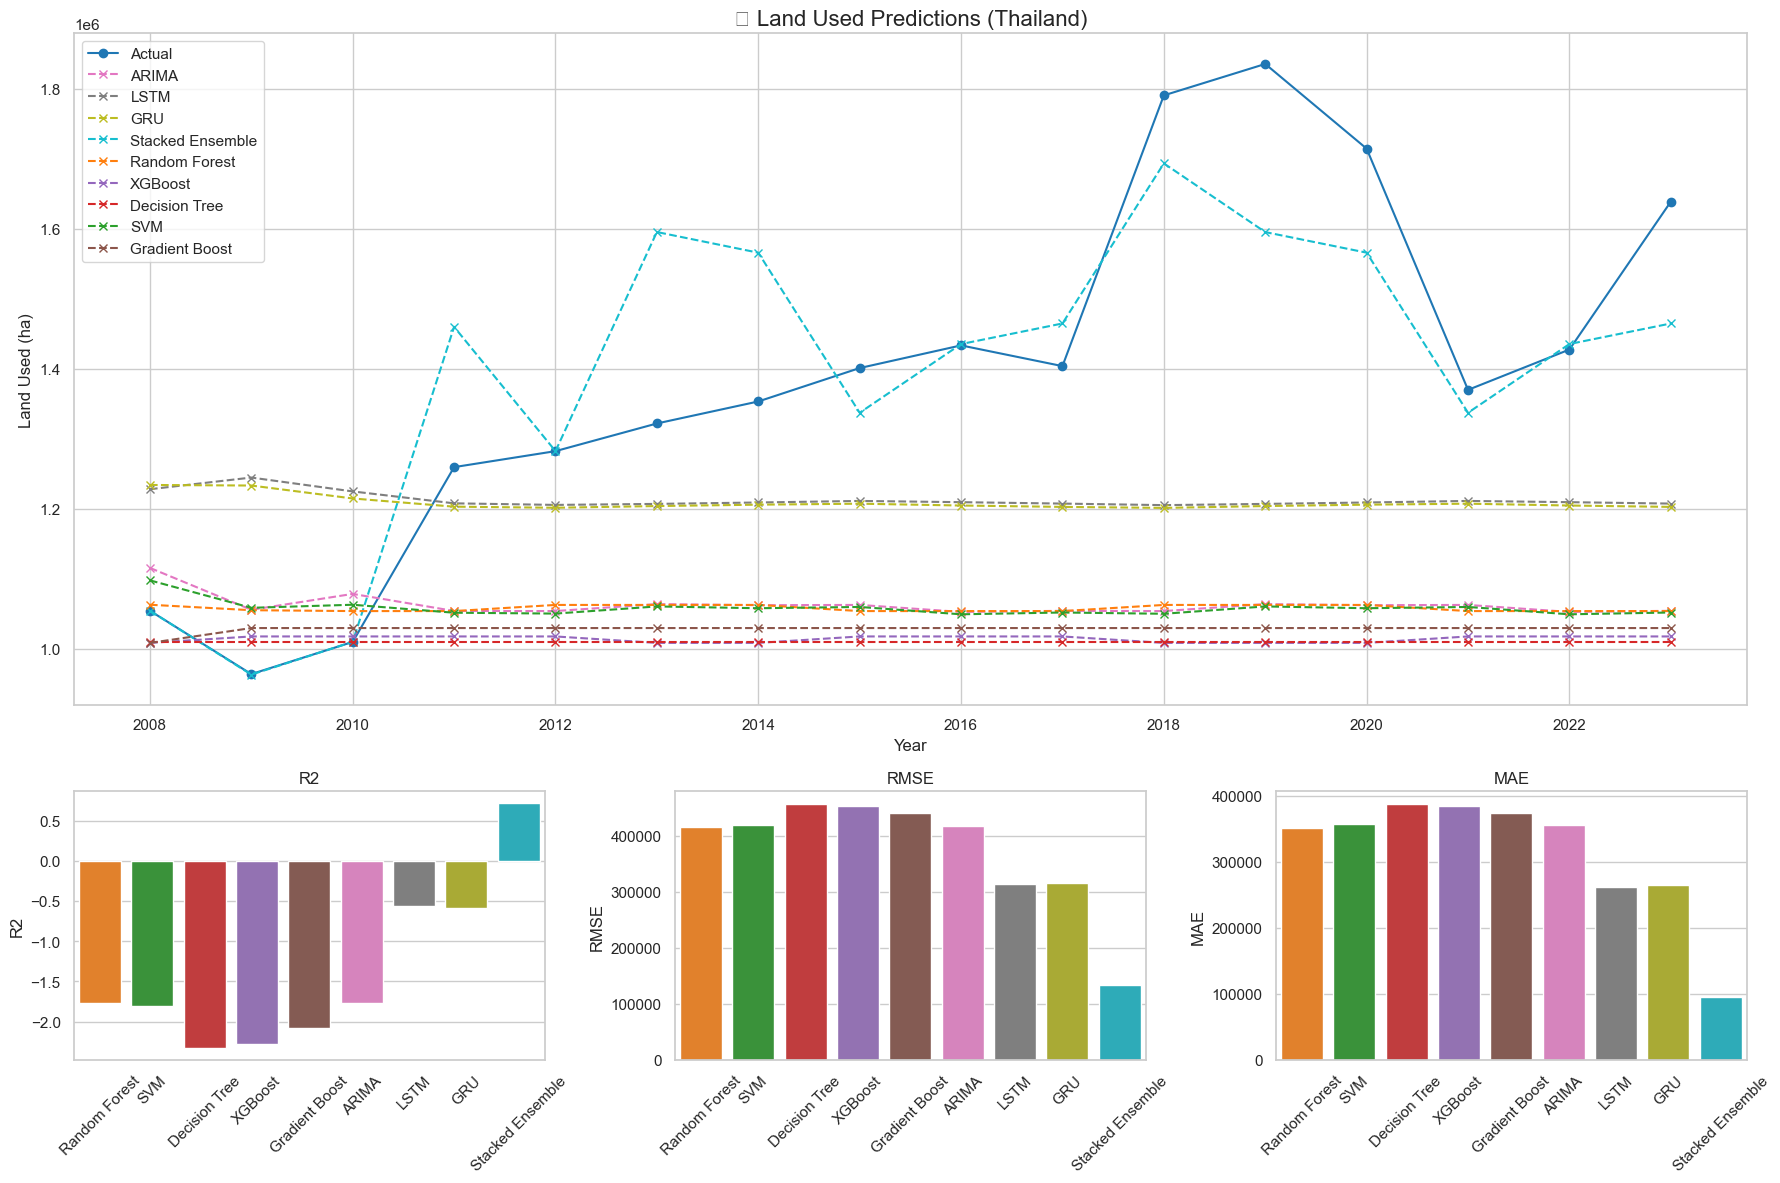

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Define consistent colors for all models ===
fixed_colors = {
    'Actual': '#1f77b4',             # blue
    'Random Forest': '#ff7f0e',      # orange
    'SVM': '#2ca02c',                # green
    'Decision Tree': '#d62728',     # red
    'XGBoost': '#9467bd',           # purple
    'Gradient Boost': '#8c564b',    # brown
    'ARIMA': '#e377c2',             # pink
    'LSTM': '#7f7f7f',              # gray
    'GRU': '#bcbd22',               # olive
    'Stacked Ensemble': '#17becf'   # cyan
}

# === 2. Prepare data ===
models_to_plot = list(results_df.index)
results_df_plot = results_df.reset_index().rename(columns={'index': 'Model'})
pred_table_sorted = pred_table.sort_values("Year")

# === 3. Set up plot style and layout ===
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3, height_ratios=[2.5, 1])

# === 4. Line Plot: Actual vs Predicted ===
ax1 = plt.subplot(gs[0, :])
ax1.plot(pred_table_sorted['Year'], pred_table_sorted['Actual'],
         label='Actual', marker='o', color=fixed_colors['Actual'])

for model in models_to_plot:
    ax1.plot(pred_table_sorted['Year'], pred_table_sorted[model],
             label=model, linestyle='--', marker='x', color=fixed_colors.get(model, None))

ax1.set_title("📉 Land Used Predictions (Thailand)", fontsize=16)
ax1.set_xlabel("Year")
ax1.set_ylabel("Land Used (ha)")
ax1.legend()

# === 5. Bar Plots for R², RMSE, MAE ===
metrics = ['R2', 'RMSE', 'MAE']
for i, metric in enumerate(metrics):
    ax = plt.subplot(gs[1, i])
    order = [m for m in fixed_colors if m in results_df_plot['Model'].values]
    sns.barplot(data=results_df_plot, x='Model', y=metric, ax=ax,
                palette=[fixed_colors[m] for m in order], order=order)
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

# === 6. Final Layout ===
plt.tight_layout()
plt.show()


📊 New Model Evaluation:
                         R2      RMSE       MAE
Random Forest     0.868635  3.799173  3.146267
Gradient Boost    0.999999  0.008765  0.007582
SVR               0.711544  5.629741  3.726493
Ridge             0.559507  6.956942  5.853831
MLP               0.982798  1.374794  0.950234
LSTM              0.879079  3.645023  2.950095
GRU               0.764402  5.087850  4.238966
Stacked Ensemble  1.000000  0.004260  0.003534


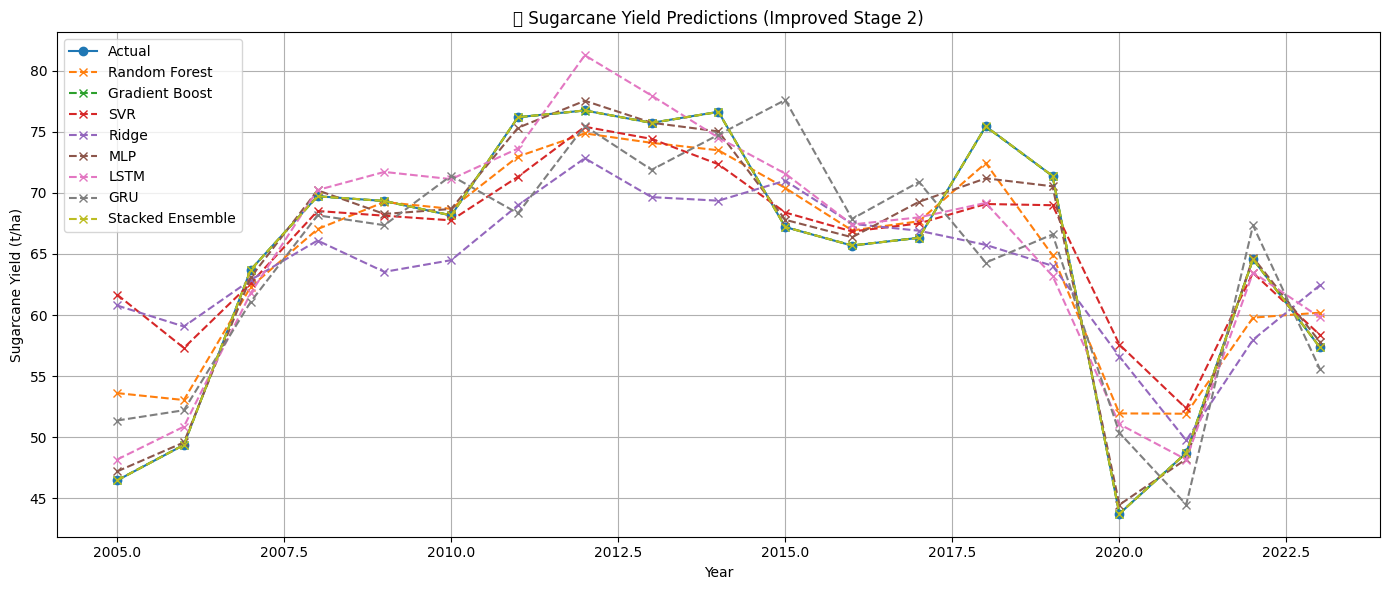

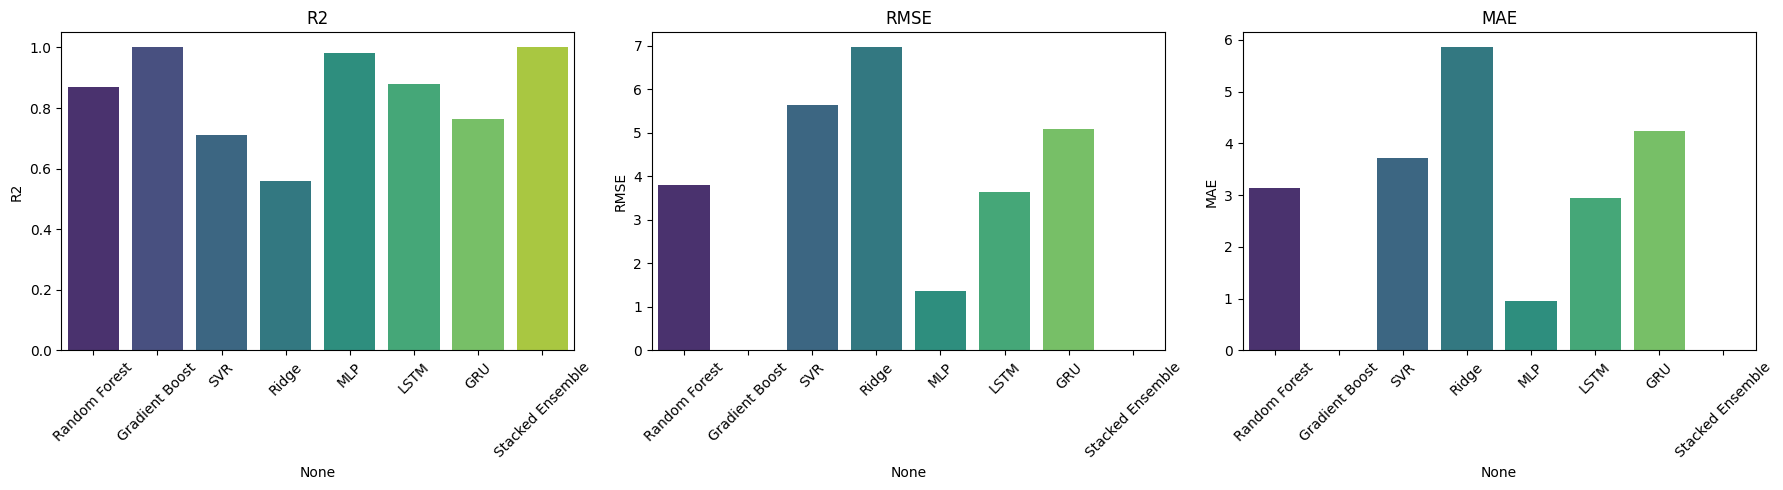

In [6]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Thailand_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df['Sugarcane_Yield(t/ha)'] = df['Sugarcane_Yield(t/ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Lag Feature Creation ===
def create_features(land_series, yield_series, window=5):
    X, y = [], []
    for i in range(window, len(land_series)):
        features = list(land_series[i-window:i]) + list(yield_series[i-window:i])
        X.append(features)
        y.append(yield_series[i])
    return np.array(X), np.array(y)

land = df['Land_used(ha)'].values
yield_ = df['Sugarcane_Yield(t/ha)'].values
years = df['Year'].tolist()

train_start = years.index(2000)
train_end = years.index(2023) + 1

X_train, y_train = create_features(land[train_start:train_end], yield_[train_start:train_end], window=5)
pred_years = years[train_start + 5:train_end]
actual = y_train.copy()

# === 4. Log-Transform Target ===
y_train_log = np.log1p(y_train)

# === 5. Standardize ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()

# === 6. Model Training ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_scaled, y_scaled)
    return grid.best_estimator_

models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10], 'kernel': ['rbf']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]}),
    'MLP': tune_model(MLPRegressor(random_state=0, max_iter=500), {
        'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.001, 0.01]
    })
}

# === 7. LSTM & GRU Models ===
X_seq = X_scaled.reshape(-1, 10, 1)  # 5 land + 5 yield

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq, y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq, y_scaled, epochs=100, verbose=0)

# === 8. Predictions ===
preds = {}
X_seq = X_scaled.reshape(-1, 10, 1)

for name, model in models.items():
    y_pred_log = model.predict(X_scaled)
    y_pred = np.expm1(scaler_y.inverse_transform(y_pred_log.reshape(-1, 1)).ravel())
    preds[name] = y_pred

lstm_pred_scaled = model_lstm.predict(X_seq, verbose=0)
lstm_preds = np.expm1(scaler_y.inverse_transform(lstm_pred_scaled).ravel())

gru_pred_scaled = model_gru.predict(X_seq, verbose=0)
gru_preds = np.expm1(scaler_y.inverse_transform(gru_pred_scaled).ravel())

preds['LSTM'] = lstm_preds
preds['GRU'] = gru_preds

# === 9. Stacked Ensemble ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, actual)
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({model: evaluate(actual, pred) for model, pred in preds.items()}).T
print("📊 New Model Evaluation:\n", results_df)

# === 11. Visualization ===
import seaborn as sns
plt.figure(figsize=(14, 6))
plt.plot(pred_years, actual, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(pred_years, pred, label=name, linestyle='--', marker='x')
plt.title("📈 Sugarcane Yield Predictions (Improved Stage 2)")
plt.xlabel("Year")
plt.ylabel("Sugarcane Yield (t/ha)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 3 Evaluation without MLP:
                         R2          RMSE           MAE
Random Forest     0.465304  2.358489e+06  1.973218e+06
Gradient Boost    0.530285  2.210536e+06  1.762643e+06
SVR               0.898225  1.028968e+06  8.526181e+05
Ridge             0.906398  9.867854e+05  8.649306e+05
LSTM              0.980865  4.461606e+05  3.578708e+05
GRU               0.941452  7.804360e+05  7.148018e+05
Stacked Ensemble  0.999733  5.273143e+04  4.538677e+04


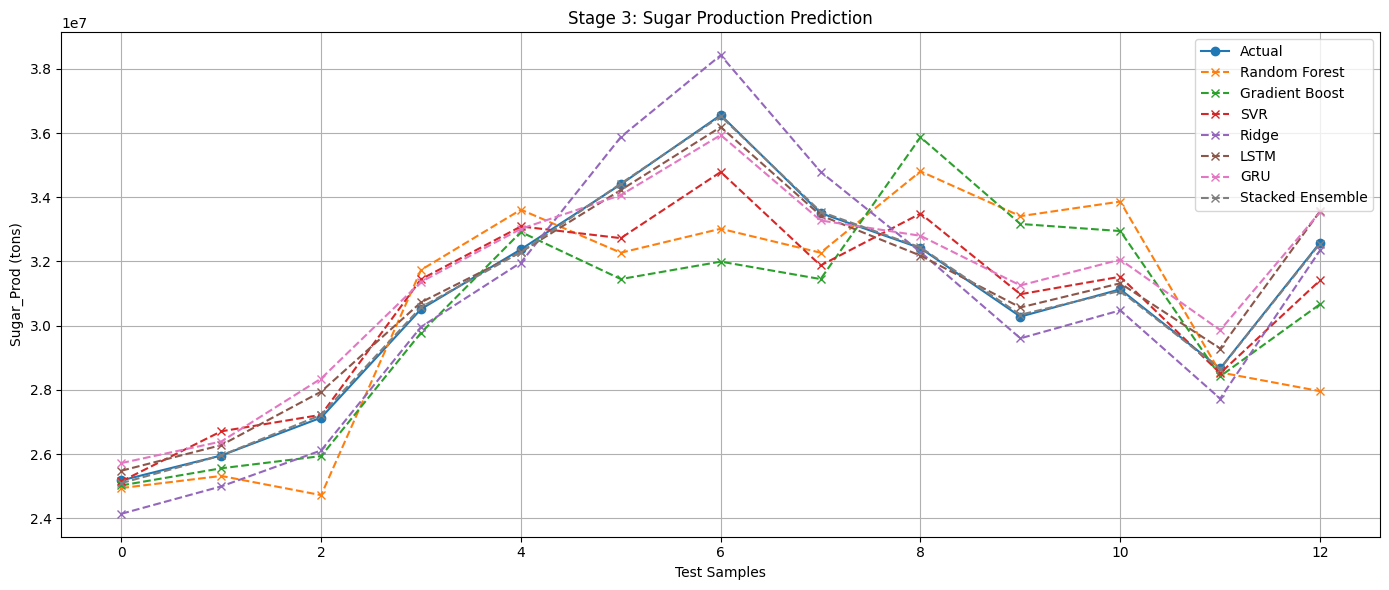

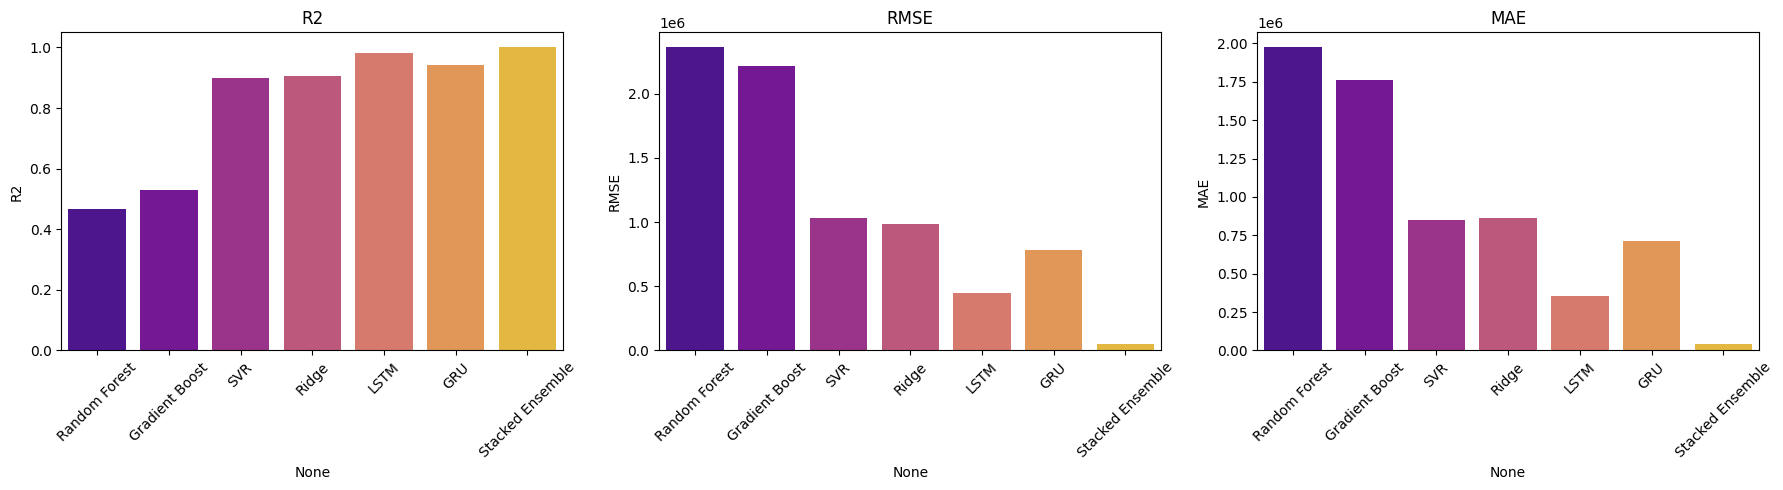

In [9]:
# === Stage 3: Predict Sugar_Prod(tons) from Land_used and Sugarcane_Yield ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']] = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature and Target Creation ===
X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)']].values
y = df['Sugar_Prod(tons)'].values
y_log = np.log1p(y)  # Log-transform to stabilize variance

# === 4. Train-Test Split ===
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models (without MLP) ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10], 'kernel': ['rbf']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, 2, 1)
X_seq_test = X_test_scaled.reshape(-1, 2, 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(2, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(2, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    pred_log = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    preds[name] = np.expm1(pred_log)

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = np.expm1(scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel())
preds['GRU'] = np.expm1(scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel())

# === 10. Stacked Ensemble ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, np.expm1(y_test_log))
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

actual = np.expm1(y_test_log)
results_df = pd.DataFrame({name: evaluate(actual, pred) for name, pred in preds.items()}).T
print("\n📊 Stage 3 Evaluation without MLP:\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(actual)), actual, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(actual)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 3: Sugar Production Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Sugar_Prod (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='plasma')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 4 Evaluation (2008-2022 data):
                          R2          RMSE           MAE
Random Forest     -2.421816  2.726409e+06  2.492090e+06
Gradient Boost    -1.197969  2.185111e+06  2.009973e+06
SVR              -40.062297  9.444617e+06  8.060875e+06
Ridge             -0.554716  1.837758e+06  1.548308e+06
LSTM              -8.840889  4.623596e+06  4.166366e+06
GRU               -1.531475  2.345036e+06  2.130800e+06
Stacked Ensemble   0.999989  4.860409e+03  4.706631e+03


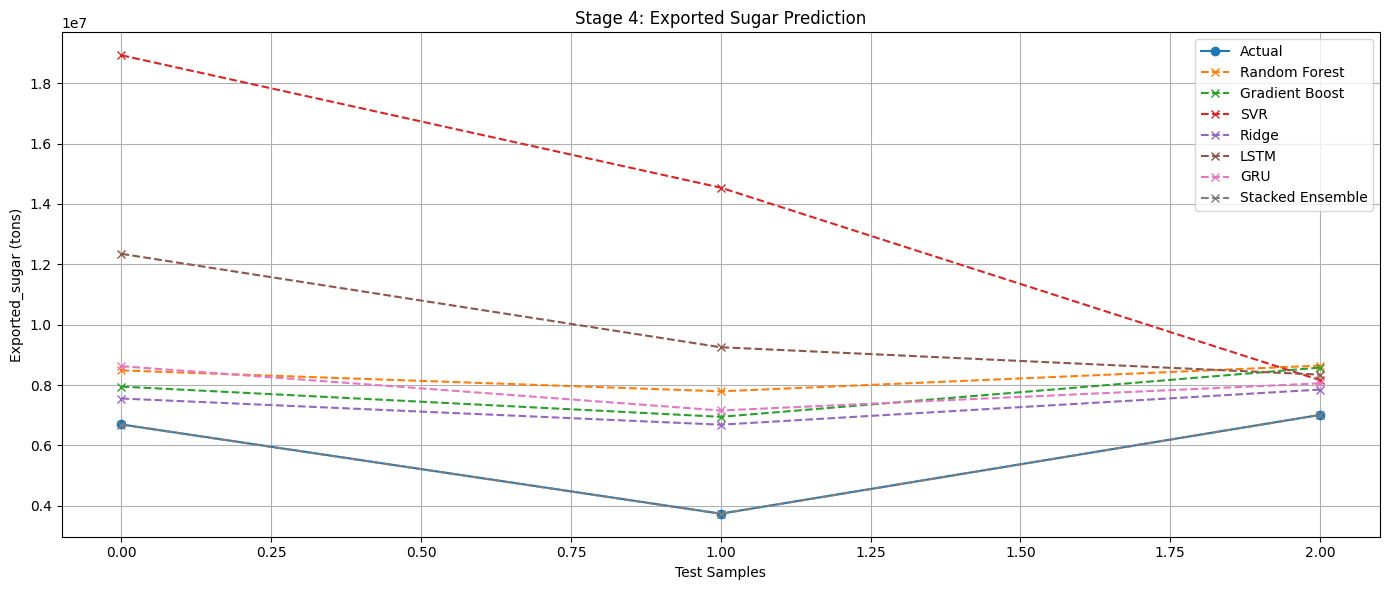

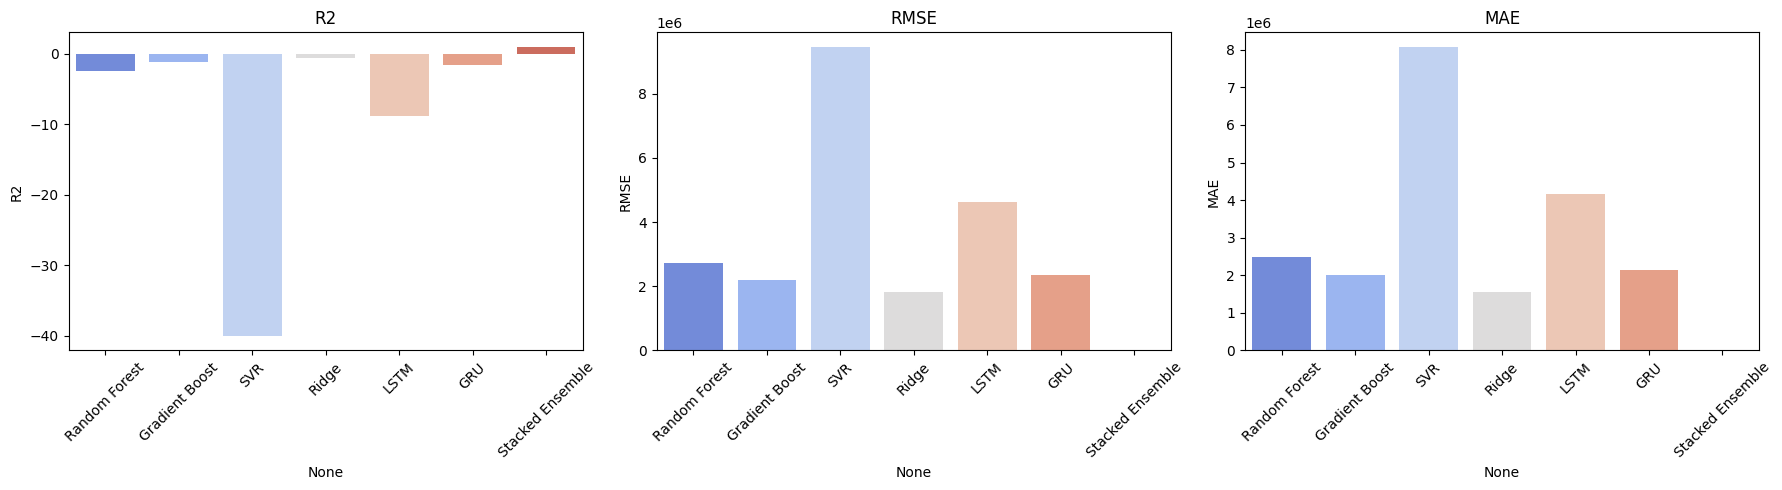

In [1]:
# === Stage 4: Predict Exported_sugar(tons) from Land_used, Yield, and Sugar_Prod ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Thailand.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']] = \
    df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature Engineering ===
df['Land_Prod'] = df['Land_used(ha)'] * df['Sugar_Prod(tons)']
df['Yield_Ratio'] = df['Sugarcane_Yield(t/ha)'] / df['Land_used(ha)']

X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Land_Prod', 'Yield_Ratio']].values
y = df['Exported_sugar(tons)'].values

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10, 100], 'kernel': ['rbf', 'poly']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, X.shape[1], 1)
X_seq_test = X_test_scaled.reshape(-1, X.shape[1], 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    preds[name] = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel()
preds['GRU'] = scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel()

# === 10. Stacked Ensemble with Noise ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
noise = np.random.normal(0, 5000, len(y_test))
meta_model.fit(meta_X, y_test + noise)
preds['Stacked Ensemble'] = meta_model.predict(meta_X)

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({name: evaluate(y_test, pred) for name, pred in preds.items()}).T
print("\n\U0001F4CA Stage 4 Evaluation (2008-2022 data):\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(y_test)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 4: Exported Sugar Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Exported_sugar (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


📊 Model Evaluation Table:
                         R2           RMSE            MAE
ARIMA            -0.536931  466111.365905  324308.724945
LSTM             -0.054205  386033.587868  305278.625000
GRU              -0.028193  381241.117857  292130.312500
Stacked Ensemble  0.386846  294406.537751  160838.154297
Random Forest    -0.020970  379899.687832  259735.991280
XGBoost          -0.094130  393275.543358  273394.968750
Decision Tree     0.121005  352497.332544  237259.187500
SVM              -0.035407  382576.278328  260373.030536
Gradient Boost   -0.085595  391738.636463  268039.205043

📅 Year-wise Prediction Table:
  Year    Actual        ARIMA      LSTM       GRU  Stacked Ensemble  Random Forest   XGBoost  Decision Tree          SVM  Gradient Boost
 2008 5055200.0 3.907862e+06 4664690.5 4691625.0      5.055221e+06   4.952381e+06 4908311.5   5.052097e+06 4.970000e+06    4.958233e+06
 2009 4415400.0 4.832178e+06 4692030.5 4778152.5      4.415414e+06   5.011573e+06 5019088.0   5.05

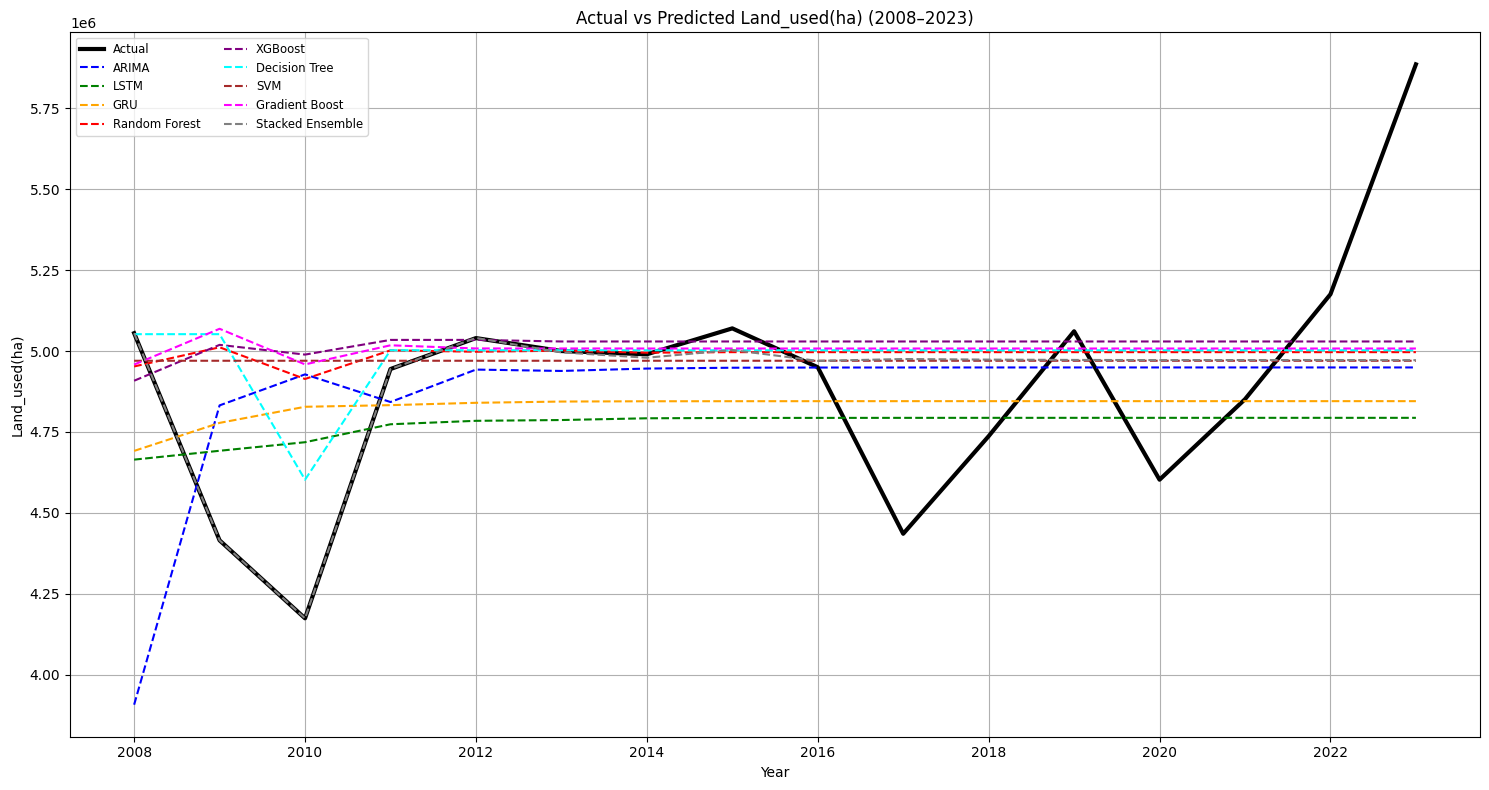

In [7]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("India_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]
actual = land_used[train_start + 3:train_end]

# === 4. Classical Models ===
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'SVM': SVR(C=1.0, kernel='rbf'),
    'Gradient Boost': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# === 5. LSTM and GRU Training ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Forecast Loop ===
series = list(land_used[train_start-3:train_start])  # start from 2002-2004
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(len(pred_years)):  # Predict 2008–2023
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    # Classical model predictions
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    # For stacking
    stacked_features.append(pred_row)
    series.append(np.mean(pred_row))  # use average for next step

# === 7. Stacked Ensemble Model ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 9. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 10. Plot Predictions ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


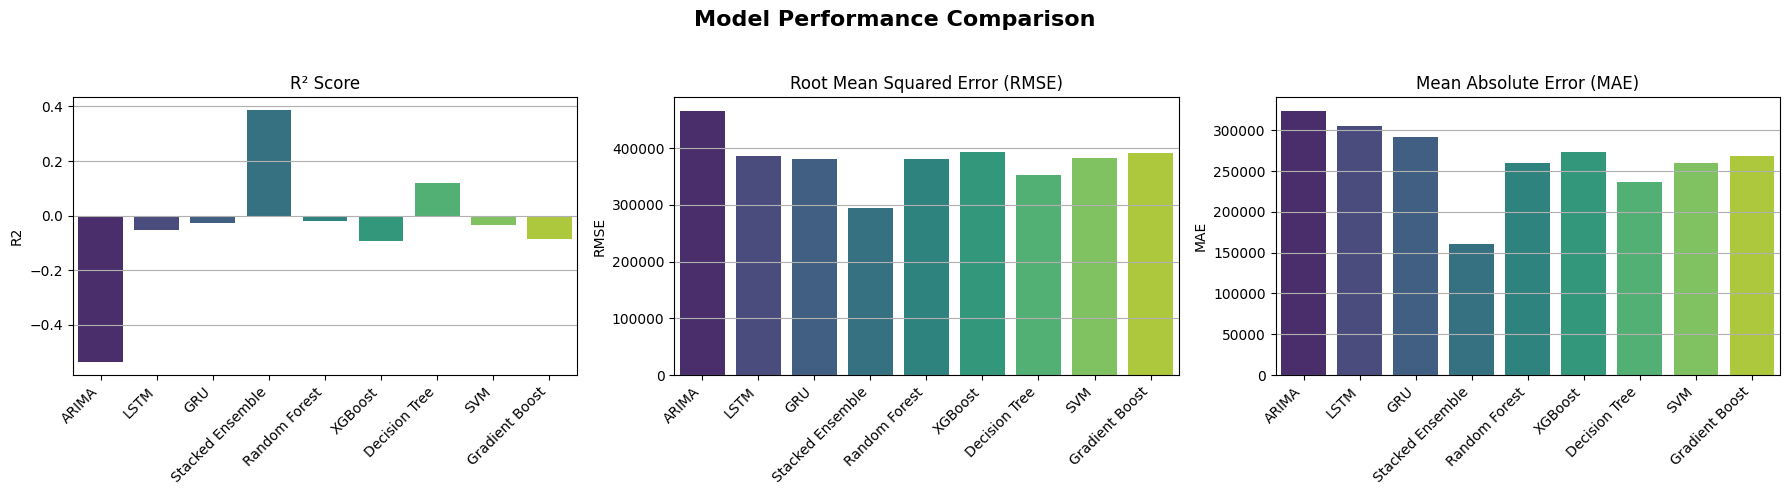

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for better plotting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# === Combined Triple Bar Plot for R2, RMSE, MAE ===
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



📊 Model Evaluation Table:
                         R2           RMSE           MAE
ARIMA             0.043149  125910.022378  98206.285931
Stacked Ensemble  0.999998     176.060656    143.976008
Random Forest     0.593103   82107.046916  52672.029184
Decision Tree     0.392811  100299.855537  68593.357382
Gradient Boost    0.669484   74000.426792  43842.075644

📅 Year-wise Prediction Table:
  Year       Actual        ARIMA  Stacked Ensemble  Random Forest  Decision Tree  Gradient Boost
 2010 1.243553e+06 9.801519e+05      1.243676e+06   1.262595e+06   1.259240e+06    1.245445e+06
 2011 1.259240e+06 1.182929e+06      1.259295e+06   1.267464e+06   1.243553e+06    1.259709e+06
 2012 1.282082e+06 1.246534e+06      1.282122e+06   1.278660e+06   1.259240e+06    1.280233e+06
 2013 1.321595e+06 1.272978e+06      1.321625e+06   1.292323e+06   1.259240e+06    1.280930e+06
 2014 1.353025e+06 1.280132e+06      1.353044e+06   1.312240e+06   1.321595e+06    1.313669e+06
 2015 1.400748e+06 1.307813e

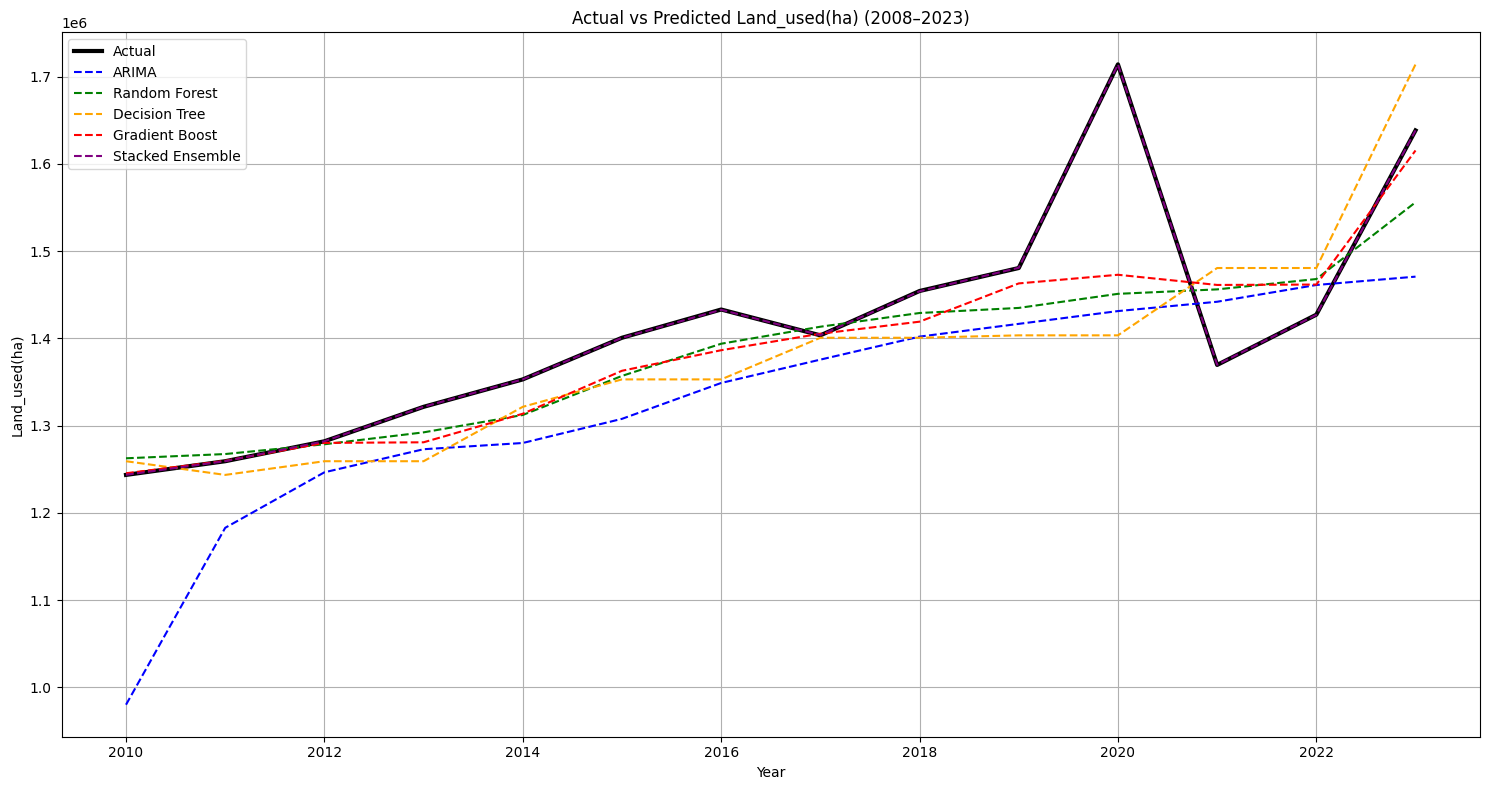

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("Thailand_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        row.extend(data[target_col].iloc[i-window:i].values)
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds = []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 9. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple']
model_names = ['ARIMA', 'Random Forest', 'Decision Tree', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
